# Datavalanche

## Exploratory data analysis of the SLF deadly avalanche dataset

In [202]:
%load_ext autoreload
%autoreload 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import folium
from folium import plugins
%aimport helpers
import calendar
import datetime
import seaborn as sns
#import pygrib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def parsedate(ts):
    return date.fromtimestamp(int(ts))

data = pd.read_csv('data/avalanches.csv', parse_dates=['date_posix_ts'], date_parser=parsedate)

In [3]:
data.head()

,winter,date_posix_ts,canton,community,starting_zone_Y,starting_zone_X,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level
0,2015/16,2016-07-04,VS,Baltschieder,631760,138570,3440,5,E,1,1,2,0,0
1,2015/16,2016-05-05,GR,Flims,737700,197340,2900,6,ESE,1,1,1,1,0
2,2015/16,2016-04-29,VS,Naters,640290,146390,3680,11,SW,1,1,2,1,2
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,781510,135430,2810,3,NE,1,1,1,1,3
4,2015/16,2016-04-19,VS,Orsières,570830,93228,3100,2,NNE,2,1,2,1,3


Let's see how many deadly avalanches occurred each year during the last 20 years

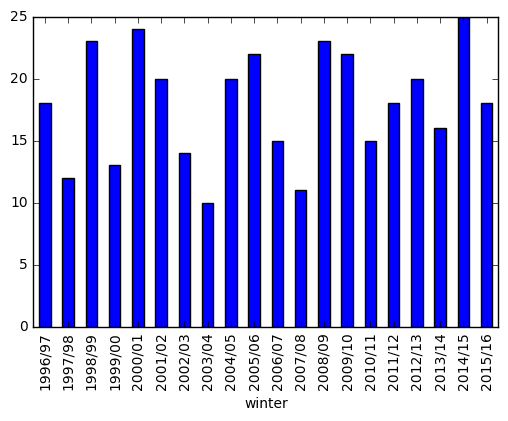

In [4]:
avalanches_per_winter = data.groupby('winter').count()['canton']
avalanches_per_winter.plot(kind='bar')

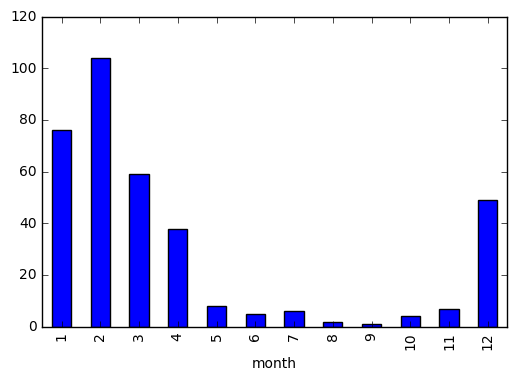

In [5]:
data['month'] = data['date_posix_ts'].map(lambda x: x.month)
avalanches_per_month = data.groupby('month').count()['canton']
avalanches_per_month.plot(kind='bar')

In [6]:
data.groupby(['winter', 'month']).count()['canton']

winter   month
1996/97  1         3
         2        12
         5         1
         7         1
         12        1
1997/98  1         5
         3         2
         4         1
         10        1
         12        3
1998/99  1         3
         2         9
         3         1
         4         2
         6         1
         7         1
         10        1
         12        5
1999/00  1         1
         2         4
         3         1
         4         2
         9         1
         11        1
         12        3
2000/01  1         4
         2        12
         3         3
         5         2
         6         1
                  ..
2011/12  2         6
         4         5
         12        5
2012/13  1         3
         2         6
         3         4
         4         3
         10        1
         11        1
         12        2
2013/14  1         2
         2         3
         3         1
         7         2
         8         1
         12        

TODO: we should try to compare this with data about total quantities of snow per year/month !


Let's now look at the aspect of the slopes where the avalanches occurred.

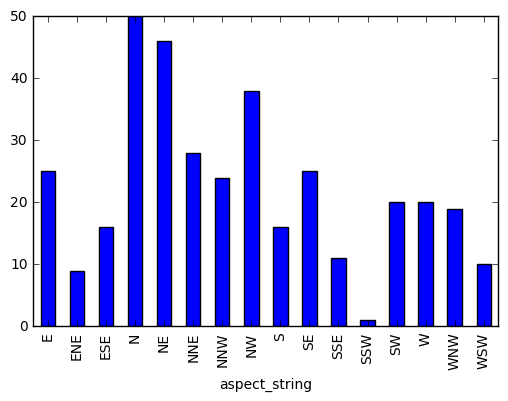

In [7]:
avalanches_per_aspect = data.groupby('aspect_string').count()['canton']
avalanches_per_aspect.plot(kind='bar')

It seems that north facing slopes are more dangerous. TODO: statistical test ?

Avalanches per danger level: TODO compare this with average proportion of days with given danger level during a winter (we should be abl to find this on the SLF website)

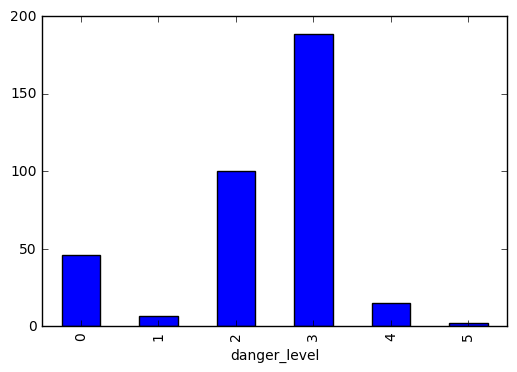

In [8]:
avalanches_per_danger = data.groupby('danger_level').count()['canton']
avalanches_per_danger.plot(kind='bar')

Let's see the distribution of avalanche starting point elevation

Mean avalanche start point elevation: 2519.9526462395543


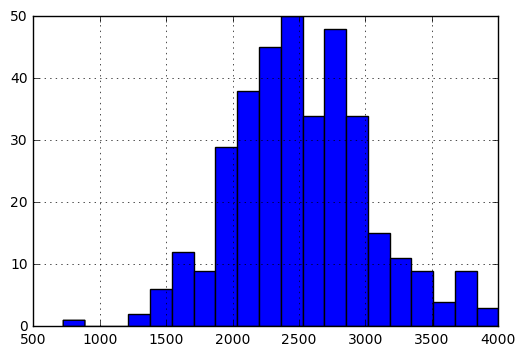

In [9]:
print('Mean avalanche start point elevation:', data['elevation'].mean())
data['elevation'].hist(bins=20)

Mean avalanche start point elevation: 2755.869918699187


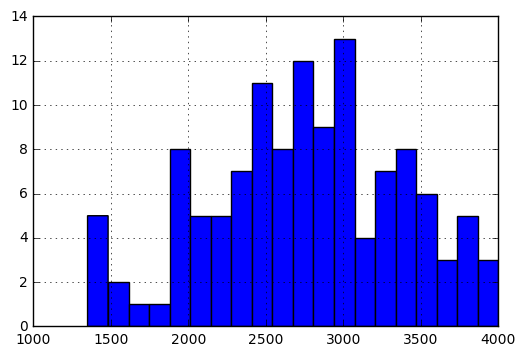

In [10]:
# TODO: maybe not so useful...
# Usually we don't go at high altitudes during the winter.
# Let's see if the mean altitude changes when not taking into account winter months
filtered_elevations = data[(data['month'] > 2) & (data['month'] < 11)]['elevation']
print('Mean avalanche start point elevation:', filtered_elevations.mean())
filtered_elevations.hist(bins=20)

# TODO: Some fancy map with avalanches per canton :D ?

In [11]:
# Get number of avalanches per canton
missing_cantons = ['ZH', 'ZG', 'SO', 'BS', 'BL', 'SH', 'JU', 'GE', 'NE','TG', 'AR', 'AG']
avalanches_per_canton = data.groupby('canton').count()[['winter']]
avalanches_per_canton.columns = [['count']]
avalanches_per_canton['count'] = avalanches_per_canton['count'].apply(lambda x: 0 if x == 0 else np.log10(x))
avalanches_per_canton = avalanches_per_canton.append(pd.DataFrame({'count':0}, index=missing_cantons))
avalanches_per_canton.reset_index(inplace=True)

In [12]:
topo_path = r'ch-cantons.topojson.json'
# Create map with log number of avalanches per canton 
av_per_canton_map = folium.Map(location=[46.8, 8.239], zoom_start=8)
av_per_canton_map.choropleth(geo_path = topo_path, data=avalanches_per_canton,
                     columns=['index', 'count'], 
                     key_on='feature.id',
                     fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
                     topojson='objects.cantons')
av_per_canton_map

KeyError: 'index'

In [14]:
# Change the stupid coordinate system in latitude/longitude
for i in data.index:
    x = data.starting_zone_X[i]
    y = data.starting_zone_Y[i]
    lat = helpers.CHtoWGSlat(x, y)
    lng = helpers.CHtoWGSlng(x, y)
    data.set_value(i, 'lat', lat)
    data.set_value(i, 'lon', lng)
    
data.drop(['starting_zone_X','starting_zone_Y'], axis=1).head()

,winter,date_posix_ts,canton,community,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level,month,lat,lon
0,2015/16,2016-07-04,VS,Baltschieder,3440,5,E,1,1,2,0,0,7,46.397737,7.851589
1,2015/16,2016-05-05,GR,Flims,2900,6,ESE,1,1,1,1,0,5,46.912888,9.246352
2,2015/16,2016-04-29,VS,Naters,3680,11,SW,1,1,2,1,2,4,46.467623,7.963174
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,2810,3,NE,1,1,1,1,3,4,46.345707,9.796747
4,2015/16,2016-04-19,VS,Orsières,3100,2,NNE,2,1,2,1,3,4,45.989984,7.062188


In [15]:
# Count the number of avalanches per community
d2 = data[['community', 'lat', 'lon']]
cnt = d2.groupby('community').count()[['lat']]
cnt.columns = ['count']
avalanches_per_community = pd.concat([d2.groupby('community').first(), cnt], axis=1)
avalanches_per_community.head()

,lat,lon,count
community,,,
Adelboden,46.447069,7.511086,7
Aeschi bei Spiez,46.595959,7.768668,1
Airolo,46.565699,8.544159,1
Alt St Johann,47.200112,9.256064,1
Altstätten,47.287387,9.511861,1


In [16]:
# Create a heat_map of avalanches
avalanches_heat_map = folium.Map(location=[46.8, 8.239], zoom_start=8, tiles='Mapbox Bright', )
avalanches_heat_map.choropleth(geo_path = topo_path, topojson='objects.cantons', fill_opacity=0.3, line_opacity=0.7), 
avalanches_heat_map_vals = avalanches_per_community.as_matrix()
avalanches_heat_map.add_children(plugins.HeatMap(avalanches_heat_map_vals, radius = 17))

most = avalanches_per_community.sort_values(by='count', ascending=False).head(10)
for index, row in most.iterrows():
    location = [row['lat'], row['lon']]
    folium.Marker(location = location, popup=index, icon = folium.Icon(color ='red')).add_to(avalanches_heat_map)
    
avalanches_heat_map

In [53]:
most

,lat,lon,count
community,,,
Davos,46.673589,9.764923,16
Zermatt,46.023963,7.632350,14
Nendaz,46.112423,7.314119,13
Anniviers,46.240161,7.616576,11
Bagnes,46.051662,7.212281,10
Orsières,45.989984,7.062188,8
Lauterbrunnen,46.556468,7.848783,8
Adelboden,46.447069,7.511086,7
Pontresina,46.417681,9.971442,6


Idea:
 - Create a more interactive map with sliders to select year/month and buttons to chose what the heatmap is about: number of victims, buried etc..   

## Meteorological data

Read the meteorological data for the 10 places with the most avalanches

In [185]:
#read the meteorological data
davos_df = pd.read_pickle('./data/pickle/davos_df.pkl')
zermatt_df = pd.read_pickle('./data/pickle/zermatt_df.pkl')
nendaz_df = pd.read_pickle('./data/pickle/nendaz_df.pkl')
anniviers_df = pd.read_pickle('./data/pickle/anniviers_df.pkl')
bagnes_df = pd.read_pickle('./data/pickle/bagnes_df.pkl')
orsieres_df = pd.read_pickle('./data/pickle/orsieres_df.pkl')
lauterbrunnen_df = pd.read_pickle('./data/pickle/lauterbrunnen_df.pkl')
adelboden_df = pd.read_pickle('./data/pickle/adelboden_df.pkl')
pontresina_df = pd.read_pickle('./data/pickle/pontresina_df.pkl')
evolene_df = pd.read_pickle('./data/pickle/evolene_df.pkl')

Some data pre-processing: 
 * convert the data from strings to floats
 * convert the temperature fields from Kelvin to Celsius
 * convert the snow fall and snow depth fields from "meters of water equivalent" to actual meters
 * for each place and time we have data for 4 different coordinates around the precise points, which form a square of ~100m sides; we want to average them

In [186]:
davos_df.name = 'davos_df'
zermatt_df.name = 'zermatt_df'
nendaz_df.name = 'nendaz_df'
anniviers_df.name = 'anniviers_df'
bagnes_df.name = 'bagnes_df'
orsieres_df.name = 'orsieres_df'
lauterbrunnen_df.name = 'lauterbrunnen_df'
adelboden_df.name = 'adelboden_df'
pontresina_df.name = 'pontresina_df'
evolene_df.name = 'evolene_df'

In [187]:
dfs = [davos_df, zermatt_df, nendaz_df, anniviers_df, bagnes_df, orsieres_df, lauterbrunnen_df, adelboden_df, pontresina_df, evolene_df]

In [147]:
columns = davos_df.columns.drop('Date')

In [184]:
#no need to execute it again

#this function is there just to make sure re-executing this cell doesn't break everything
def temp_conv(x):
    zero_kelvin = 273.15
    if(x > 100):
        return x - zero_kelvin
    elif(x < -100):
        return x + zero_kelvin
    else:
        return x
for df in dfs:  
    for column in columns:
        df[column] = df[column].astype('float')
    #convert the temperature fields into degrees celsius
    df['2 metre temperature'] = df['2 metre temperature'].map(temp_conv)
    df['Temperature of snow layer'] = df['Temperature of snow layer'].map(temp_conv)
    #convert the snow depth and snow fall into meters
    df['Snow depth'] = df['Snow depth']/(df['Snow density']/1000)
    df['Snowfall'] = df['Snowfall']/(df['Snow density']/1000)
    path = './data/pickle/'+df.name+'.pkl'
    df = df.groupby('Date', as_index=False).mean()
    df.to_pickle(path)

### Some data exploration

Rather than doing all the steps for all the datasets, which would be tedious to look at, we'll arbitrarly pick a few of them each time. First, let's look at the different parameters by month and by winter. Let's pick Zermatt and Adelboden for this one.

In [240]:
zermatt_monthly = zermatt_df.copy()
#get rid of the day
zermatt_monthly['Date'] = zermatt_monthly['Date'].map(lambda x: datetime.datetime(x.year, x.month, 1))
#group by month, averaging most of the parameters but summing the sunshine duration and snowfall
agg_functions = {}
agg_functions.update(dict.fromkeys(zermatt_monthly.columns.drop(['Date', 'Sunshine duration', 'Snowfall']), 'mean'))
agg_functions.update(dict.fromkeys(['Sunshine duration', 'Snowfall'], 'sum'))
zermatt_monthly = zermatt_monthly.groupby('Date', as_index=False).agg(agg_functions)

#same for adelboden
adelboden_monthly = adelboden_df.copy()
#get rid of the day
adelboden_monthly['Date'] = adelboden_monthly['Date'].map(lambda x: datetime.datetime(x.year, x.month, 1))
#group by month, averaging most of the parameters but summing the sunshine duration and snowfall
adelboden_monthly = adelboden_monthly.groupby('Date', as_index = False).agg(agg_functions)

In [259]:
#replace the date by the month and the winter, respectively
zermatt_month = zermatt_monthly.copy()
#keep only the month
zermatt_month['Date'] = zermatt_month['Date'].map(lambda x: x.month)
#sort by month
zermatt_month.sort_values(by='Date', inplace=True)
#replace the month by its name
zermatt_month['Date'] = zermatt_month['Date'].map(lambda x: calendar.month_name[x])
#group by month
zermatt_month = zermatt_month.groupby('Date', sort=False).mean()

zermatt_winter = zermatt_monthly.copy()
#replace the date by the winter it belongs to
zermatt_winter['Date'] = zermatt_winter['Date'].map(lambda x: helpers.date_to_winter(x))
#group by winter
zermatt_winter = zermatt_winter.groupby('Date').mean()

#same for adelboden
adelboden_month = adelboden_monthly.copy()
adelboden_month['Date'] = adelboden_month['Date'].map(lambda x: x.month)
adelboden_month.sort_values(by='Date', inplace=True)
adelboden_month['Date'] = adelboden_month['Date'].map(lambda x: calendar.month_name[x])
adelboden_month = adelboden_month.groupby('Date', sort=False).mean()
adelboden_winter = adelboden_monthly.copy()
adelboden_winter['Date'] = adelboden_winter['Date'].map(lambda x: helpers.date_to_winter(x))
adelboden_winter = adelboden_winter.groupby('Date').mean()

Let's plot the average snow depth, first by month then by winter

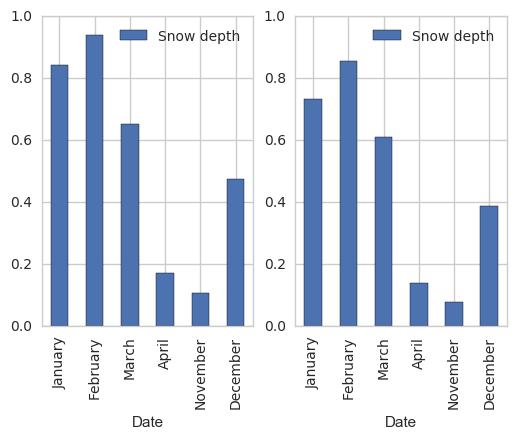

In [302]:
fig, axs = plt.subplots(1,2)
zermatt_month.plot(ax=axs[0], y='Snow depth', yticks=np.arange(0, 1.1, 0.2), kind='bar')
adelboden_month.plot(ax=axs[1], y='Snow depth', yticks=np.arange(0, 1.1, 0.2), kind='bar')

We see that there is more snow in Zermatt than in Adelboden, but the general shape is the same. Let's do the same with winters

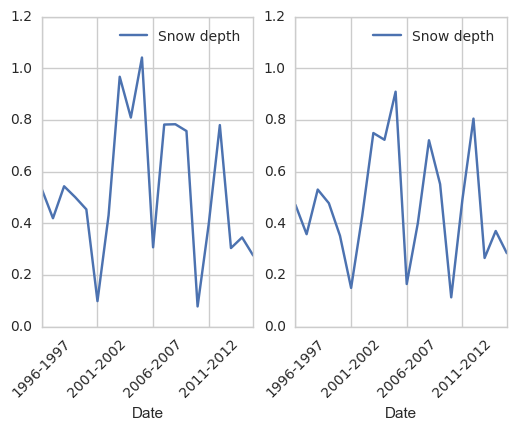

In [286]:
fig, axs = plt.subplots(1,2)
zermatt_winter.plot(ax=axs[0], y='Snow depth', yticks=np.arange(0, 1.3, 0.2))
adelboden_winter.plot(ax=axs[1], y='Snow depth', yticks=np.arange(0, 1.3, 0.2))
axs[0].set_xticklabels(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=45)

We see again that there is more snow in Zermatt, but the general shape is the same again. Let's take a look at sunshine duration now.

In [294]:
#convert the sunshine duration to hours
zermatt_month['Sunshine duration'] /=3600
adelboden_month['Sunshine duration'] /=3600

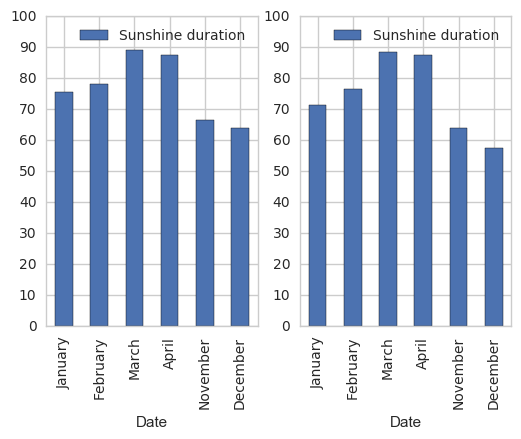

In [308]:
fig, axs = plt.subplots(1,2)
zermatt_month.plot(ax=axs[0], y='Sunshine duration', yticks=range(0, 101, 10), kind='bar')
adelboden_month.plot(ax=axs[1], y='Sunshine duration', yticks=range(0, 101, 10), kind='bar')

No big surprise there, rather similar values. The winters will probably be more interesting.

In [298]:
#convert the sunshine duration to hours
zermatt_winter['Sunshine duration'] /=3600
adelboden_winter['Sunshine duration'] /=3600

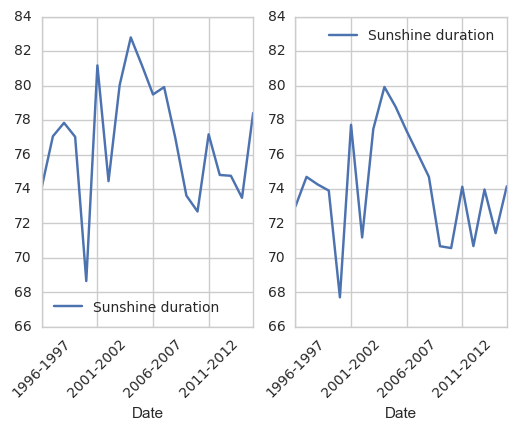

In [301]:
fig, axs = plt.subplots(1,2)
zermatt_winter.plot(ax=axs[0], y='Sunshine duration', yticks=range(66, 85, 2))
adelboden_winter.plot(ax=axs[1], y='Sunshine duration', yticks=range(66, 85, 2))
axs[0].set_xticklabels(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=45)

We see similar shapes, although different values. And the 2000-2001 winter wasn't a very nice time. Let's do it one last time, for temperatures.

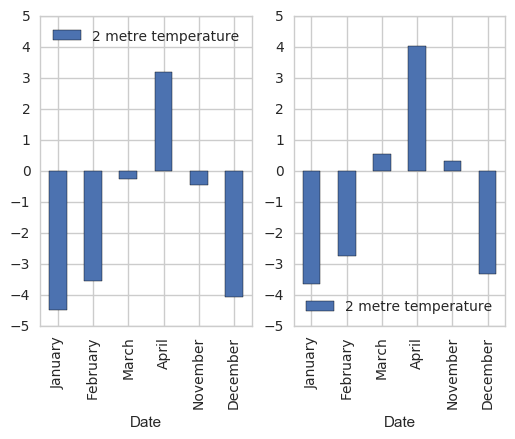

In [304]:
fig, axs = plt.subplots(1,2)
zermatt_month.plot(ax=axs[0], y='2 metre temperature', yticks=range(-5, 6), kind='bar')
adelboden_month.plot(ax=axs[1], y='2 metre temperature', yticks=range(-5, 6), kind='bar')

And for the winters.

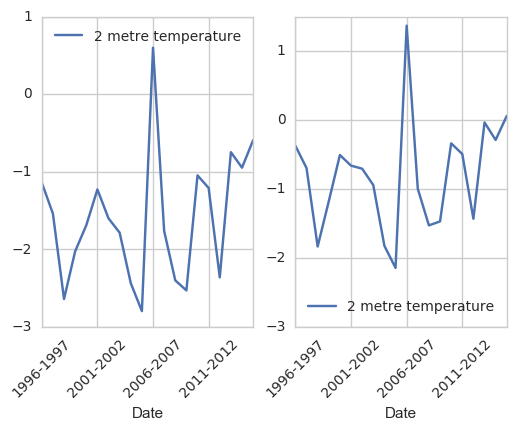

In [306]:
fig, axs = plt.subplots(1,2)
zermatt_winter.plot(ax=axs[0], y='2 metre temperature', yticks=range(-3, 2))
adelboden_winter.plot(ax=axs[1], y='2 metre temperature', yticks=range(-3, 2))
axs[0].set_xticklabels(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=45)

In [287]:
zermatt_df.loc[85]

Date                         1996-12-13 12:00:00
Latitude                                 46.0235
Longitude                                 7.6325
Snow density                             290.242
Snow depth                              0.844631
Snowfall                              0.00375864
10 metre U wind component               -0.35664
10 metre V wind component               0.480566
2 metre temperature                     -2.34676
Sunshine duration                              0
Temperature of snow layer               -5.22553
Name: 85, dtype: object

In [217]:
helpers.date_to_winter(zermatt_df.loc[0]['Date'])

'1996-1997'

In [216]:
'-' + str(-, 1)

SyntaxError: invalid syntax (<ipython-input-216-5f3f8c75200d>, line 1)

Let's plot the snow depth:

In [203]:
sns.set_style('whitegrid')

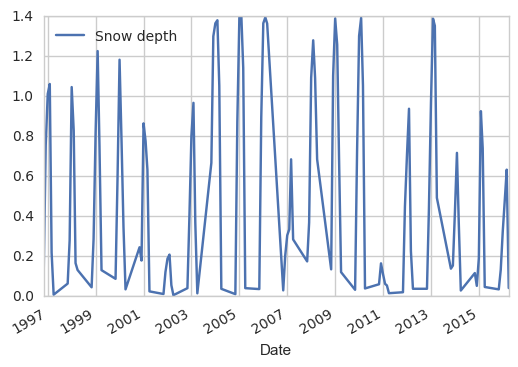

In [208]:
zermatt_monthly.plot(y='Snow depth')

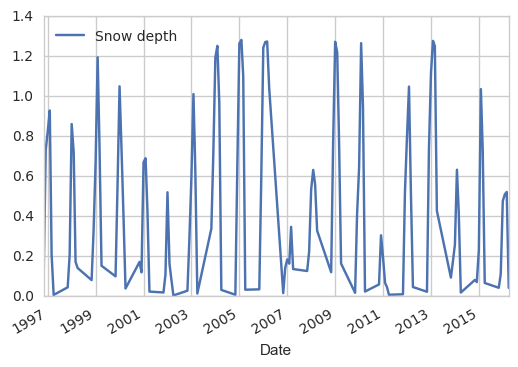

In [210]:
adelboden_monthly.plot(y='Snow depth')

2002-2003 in Zermatt wasn't much fun, was it?

In [105]:
zermatt_monthly = zermatt_df.copy()
zermatt_monthly['Date'] = zermatt_monthly['Date'].map(lambda x: calendar.month_name[x.month])
zermatt_monthly.head()

,Date,Latitude,Longitude,Snow density,Snow depth,Snowfall,10 metre U wind component,10 metre V wind component,2 metre temperature,Sunshine duration,Temperature of snow layer
0,November,46.024,7.632,276.847363,0.000123,0.0,1.540789,-0.772150,0.348438,0.000000,-4.192248
1,November,46.024,7.633,276.881754,0.000123,0.0,1.540913,-0.773798,0.346396,0.000000,-4.194446
2,November,46.023,7.632,276.893200,0.000123,0.0,1.540647,-0.775422,0.346447,0.000000,-4.194156
3,November,46.023,7.633,276.927727,0.000123,0.0,1.540773,-0.777070,0.344407,0.000000,-4.196354
4,November,46.024,7.632,279.464287,0.000099,0.0,1.726122,-1.929958,6.147258,10640.557007,-0.990088
